In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


import scipy.stats as stats 
from scipy.stats import chi2_contingency, boxcox

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm 

In [7]:
df = pd.read_csv('Maternal-risk-processed.csv')

# PREDICCIÓN DE RIESGO MATERNAL CON ALGORITMO SVM

Como hemos observado con KNN, hay un desequilibrio de clases y es por eso por lo que 
el algoritmo no es capaz de reconocer la clase 1 correctamente. Para resolver este problema, asignaremos pesos 
a las clases (<code>weights</code>). Como tenemos un total de 452 muestras, de las cuales 234 pertenecen a la clase 0, 
112 a la clase 1 y 106 a la clase 2, vamos a asignar: 0.2, 0.4, 0.4 respectivamente. 

## Separación de características y objetivo

In [13]:
x = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

## ENTRENAMIENTO DEL MODELO

In [16]:
#Separamos datos entre muestra de entrenamiento y muestra de test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101, stratify=y)

In [18]:
class_weight = {0:0.2, 1:0.5, 2:0.3}

In [20]:
#Creamos y ajustamos modelo SVC

svc = SVC(class_weight=class_weight, C = 1, kernel = 'poly', degree = 5, coef0= 1.0,  gamma='scale', tol = 1e-2,  shrinking = True, probability=False)
svc.fit(X_train, y_train.values.ravel())

#Hacemos predicciones
svcKernel_pred=svc.predict(X_test)

#Evalúa modelo
print('SVM\n')
print(confusion_matrix(y_test, svcKernel_pred))
print('\n')
print(classification_report(y_test, svcKernel_pred))

SVM

[[59 11  0]
 [19 11  2]
 [ 6 10 18]]


              precision    recall  f1-score   support

           0       0.70      0.84      0.77        70
           1       0.34      0.34      0.34        32
           2       0.90      0.53      0.67        34

    accuracy                           0.65       136
   macro avg       0.65      0.57      0.59       136
weighted avg       0.67      0.65      0.64       136



Vamos a volver a usar GridSearch para optimizar los parámetros y encomtrar un mejor resultado para la identificación de la Clase1.

**Hiperparámetros a evaluar**
<ul>
    <li>C: parámetro de regulación, mayor valor reducen la regulación.</li>
    <li>kernel: define tipo núcleo usado pr el SVM: lineal, RBF, polinómico, etc.</li>
    <li>gamma:controla la influencia de los puntos individuales</li>
    <li>degree: relevante si <code>kernel='poly'</code>, indica el grado del polinomio.</li>
    <li>coef0: constante en los kernels 'poly' y 'sigmoid'.</li>
    <li>class_weight: pondera las clases para manejar el desbalence de clases. Si usamos la opción balanced ajusta automática,ente según la proporción de clases, None es por defecto, sin ponderación. </li>
    <li>shrinking: activa o desactiva el algoritmo de optimización de shrinking, Este valor puede etar a True o False.</li>
    <li>probability: si se debe habilitar la estimación de probabilidades, pero agrega tiempo de entrenamiento.</li>
    <li>tol: criterio de tolerancia para la convergencia del modelo.</li>
    <li> max_iter: número máximo de iteraciones para la optimización, -1 significa sin límite.</li>
    
</ul>

In [24]:
from sklearn.svm import SVC
svm = SVC(random_state=42)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 200],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
    'degree': [2, 3, 4, 5],
    'coef0': [0.0, 0.1, 0.5, 1.0],
    'class_weight': [None, 'balanced'],
    'shrinking': [True, False],
    'probability': [False],  # Cambiar a [True, False] si se requieren probabilidades.
    'tol': [1e-4, 1e-3, 1e-2],
    'max_iter': [100, 1000],
}
# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("los mejores hiperparámetros encontrados", grid_search.best_params_)

#Probamos el modelo con los mejores hiperparámetros

best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

# Evaluación del modelo
print("Precisión en el conjunto de prueba:", accuracy_score(y_test, y_pred))
print("Reporte de la clasificación:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 55296 candidates, totalling 276480 fits


KeyboardInterrupt: 

In [71]:
#Creamos y ajustamos modelo SVC con los mejores parámetros

svc = SVC(class_weight='balanced', C = 200, kernel = 'linear', degree = 5, coef0= 1.0,  gamma='auto', tol = 0.001,  shrinking = True, probability=False)
svc.fit(X_train, y_train.values.ravel())

#Hacemos predicciones
svcKernel_pred=svc.predict(X_test)

#Evalúa modelo
print('SVM\n')
print(confusion_matrix(y_test, svcKernel_pred))
print('\n')
print(classification_report(y_test, svcKernel_pred))

SVM

[[38 32  0]
 [ 8 19  5]
 [ 3 14 17]]


              precision    recall  f1-score   support

           0       0.78      0.54      0.64        70
           1       0.29      0.59      0.39        32
           2       0.77      0.50      0.61        34

    accuracy                           0.54       136
   macro avg       0.61      0.55      0.55       136
weighted avg       0.66      0.54      0.57       136



In [73]:
from sklearn.model_selection import cross_val_score

# Validación cruzada
scores = cross_val_score(svc, X_train, y_train, cv=5)

print("Cross-validation scores:", scores)
print(f"Mean CV Accuracy: {scores.mean():.2f}")

Cross-validation scores: [0.59375    0.49206349 0.50793651 0.57142857 0.55555556]
Mean CV Accuracy: 0.54


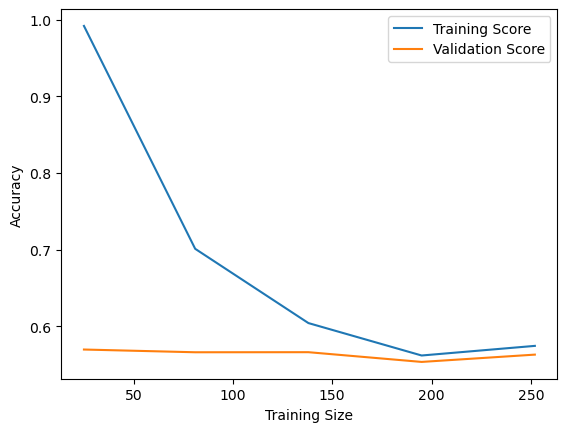

In [74]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(svc, X_train, y_train, cv=5)

# Calcular medias
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Graficar
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [75]:
import joblib
joblib.dump(svc, 'maternal-risk-svc-model.pkl')
print("Modelo guardado como 'maternal_risk_model.pkl'")

Modelo guardado como 'maternal_risk_model.pkl'


## PRUEBA CON NUESTROS DATOS

In [89]:
wearable_data = pd.read_csv('wearable-simulation-pregnancy.csv')

In [91]:
wearable_data.head()

,user_id,Age,timestamp,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate,day,month&year,date,week,trimester
0,user_0000,32,2024-06-16 02:45:05,89.0,134.0,8.26,98.696800,100.0,2024-06-16,2024-06,2024-06-16,3,First
1,user_0000,32,2024-06-16 10:45:05,87.0,130.0,8.33,98.711909,108.0,2024-06-16,2024-06,2024-06-16,3,First
2,user_0000,32,2024-06-16 18:45:05,87.0,130.0,8.33,98.711909,108.0,2024-06-16,2024-06,2024-06-16,3,First
3,user_0000,31,2024-06-18 07:37:54,87.0,133.0,8.86,98.843603,121.0,2024-06-18,2024-06,2024-06-18,3,First
4,user_0000,31,2024-06-18 15:37:54,86.0,131.0,7.99,98.870108,102.0,2024-06-18,2024-06,2024-06-18,3,First


In [93]:
wearable_data['week'].nunique()

25

In [105]:
# Agrupamos los datos por user_id y day para calcular el promedio diario de los isgnos vitales

daily_data = wearable_data.groupby(['user_id', 'date']).agg({
    'Age': 'first', 
    'DiastolicBP': 'mean',
    'SystolicBP': 'mean',
    'BS': 'mean',
    'BodyTemp': 'mean',
    'HeartRate': 'mean',
     # La edad no varía durante el embarazo
}).reset_index()
daily_data.head()


,user_id,date,Age,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate
0,user_0000,2024-06-16,32,87.666667,131.333333,8.306667,98.706873,105.333333
1,user_0000,2024-06-18,31,86.333333,131.666667,8.280000,98.861273,108.333333
2,user_0000,2024-06-19,32,87.666667,130.333333,8.243333,98.678435,108.333333
3,user_0000,2024-06-20,32,86.666667,130.333333,8.280000,98.566905,107.666667
4,user_0000,2024-06-22,32,86.000000,131.000000,8.400000,98.706873,107.666667


In [97]:
daily_data = daily_data.merge(wearable_data[['user_id', 'date', 'week', 'trimester']], 
                              on=['user_id', 'date'], 
                              how='inner')

daily_data.head()

,user_id,date,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate,Age,week,trimester
0,user_0000,2024-06-16,87.666667,131.333333,8.306667,98.706873,105.333333,32,3,First
1,user_0000,2024-06-16,87.666667,131.333333,8.306667,98.706873,105.333333,32,3,First
2,user_0000,2024-06-16,87.666667,131.333333,8.306667,98.706873,105.333333,32,3,First
3,user_0000,2024-06-18,86.333333,131.666667,8.280000,98.861273,108.333333,31,3,First
4,user_0000,2024-06-18,86.333333,131.666667,8.280000,98.861273,108.333333,31,3,First


In [99]:
modelSVC = joblib.load('maternal-risk-svc-model.pkl')
print("Modelo cargado exitosamente")

Modelo cargado exitosamente


In [107]:
# Hacemos predicciones con modelo entrenado
X_daily = daily_data[['Age','DiastolicBP', 'SystolicBP', 'BS', 'BodyTemp', 'HeartRate']]
daily_data['risk'] = modelSVC.predict(X_daily)
daily_data.head(10)

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.
